Atest
Bursts\Atest\Burst000.xlsx
[START: 22979; END: 39821; WIDTH: 16842; HEIGHT: -66.58815792064615
, START: 60681; END: 77508; WIDTH: 16827; HEIGHT: -69.63969227197539
]
Bursts\Atest\Burst001.xlsx


KeyboardInterrupt: 

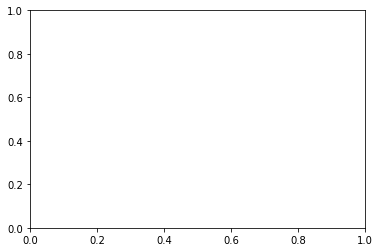

In [2]:

# This program is meant to help create features from a set of files which contain IQ data collected from devices
# Main Variables: (1) path = a folder where bursts for different devices are saved. The subdirectories of 'path' should be 
#                         other folders which themselves contain burst files
#                   (2) Global noise = noise floor
#                   (3) savePlotsTo = directory to save plots of signals to 


# Manzi Bryan, Summer 2019
# As part of the KotzGroup

import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.interpolate import spline
from path import Path
from os import listdir
import os
from os.path import isfile, join
import shutil
from scipy import signal

# Global Variables

noise = -85



# Class to help define signal peaks
class Peak:
    def __init__(self, start, end, height):
        self.start = start
        self.end = end
        self.width = end - start
        self.height = height # whisker height not absolute height of burst!
        
    # Getter methods
    def getStart(self):
        return self.start
    def getEnd(self):
        return self.end
    def getWidth(self):
        return self.width
    def getHeight(self):
        return self.height      
    
    #Printing methods
    def __str__(self):
        return "START: " + str(self.start) + "; END: " + str(self.end) + "; WIDTH: " + str(self.width) + "; HEIGHT: " + str(self.height)
    def __repr__(self):
        return str(self) + '\n'
    
    
# Takes a string representing the IQ data of a signal, converts string to complex number and returns signal amplitude
def amplitude(val):
    global noise
    if val == '0j' or val == '' or val == '0':# if the signal is approcimate to 0, amplitude might as well be noise
        return noise 
    
    value = val
    val = val.replace('(','').replace(')','').replace('j','')
    i = 0
    length = len(val)
    real = ''
    imaginary = ''
    
    while i < length:
        if i > 0 and (val[i] == '-' or val[i] == '+'):
            imaginary = val[i:]
            break
        
        if not val[i] == 'e':
            real += val[i]
            i+=1    
        
        elif val[i] == 'e':
            real += val[i:i+4]
            i+=4
            imaginary = val[i:]
            i = length
            
    if imaginary == '':
        if 'j' in value:
            imaginary = real
            real = '0'
        else:
            imaginary = '0'
    real = float(real)  #extract real part and convert to a float
    imaginary = float(imaginary) #remove the space between the sign and number for imaginary and convert to float
    
    refLevDBM = 30
    absComplex = abs(complex(real, imaginary))
    
    try:
        sigDB = 20* math.log(absComplex, 10)
        
    except: # Should never be triggered since absComplex should be > 0
        print("val is " + val)
        print("abscomplex is " + absComplex)
        print(sigDB)
        
    sigDBM = sigDB + 30 - refLevDBM
    
    return sigDBM 


       
def whiskerStDev(df, peak):
     # this method is meant to find the standard deviation between 
    # the top and bottom end of the whisker. To achieve this, I will 
    # find the center of the peak, and look for the max and min of the 
    # center left and center right of the whisker
    
    start = peak.getStart()
    end = peak.getEnd()
    
    center = (start + end) // 2
    
    centerLeft = (center + start)//2
    centerRight = (center + end)//2
    
    stdev = df[0][centerLeft : centerRight].std()
    
    if math.isnan(stdev):
        return 0
    return stdev
    
    
   
    
def whiskerHeight(df, peak):
    # this method is meant to find the difference between the top 
    # and bottom end of the whisker. To achieve this, I will find 
    # the center of the peak, and look for the max and min of the 
    # center left and center right of the whisker
    
    start = peak.getStart()
    end = peak.getEnd()
    
    center = (start + end) // 2
    
    centerLeft = (center + start)//2
    centerRight = (center + end)//2
    
    
    maximum = df[0][centerLeft : centerRight].max()
    minimum = df[0][centerLeft : centerRight].min()
    if math.isnan(maximum) or math.isnan(minimum):
        return 0
    return maximum - minimum
    
    
def getSpace(peaks):
    return peaks[1].start - peaks[0].end


def identifyPeaks(data):
    # identifyPeaks takes a dataframe and makes an array of peaks
    #Amplitude = 0 
    
    df = data.copy() # copy the file, because we do not want to edit the actual dataframe but rather a local version of it
    numSamples = df.index.max()
    jumpBy = 1000
    roll = 100 # how wide is the moving average window
    df[0] = df[0].rolling(roll).mean()
    # TODO: Change to center and see impact
    i = 0
    peaks = []
    
    if numSamples < minWidth: # If the dataframe is smaller than the minimum length of a bluetooth
        return twoHighest(peaks) # since 'peaks' is empty, this should return two empty peaks
    
    while i < df.index.max():
        end = 0
        start = 0
        amp = df[0][i]
        if amp >= noise:
            while amp >= noise and i >= 0: #looks for peak's exact start
                i-=1
                amp = df[0][i]
            start = i
            amp = df[0][i+1]
            while amp >= noise and i + 100 <= numSamples :
                i+=100
                amp = df[0][i]
                
            while amp <= noise and i >= 0:
                i-=1
                amp = df[0][i]
                end = i
                
            if end - start >= minWidth and end != 0 and start != roll - 2:
                height = df[0][start: end].mean()
                newPeak = Peak(start, end, height)
                peaks.append(newPeak)
        i+=jumpBy
    
    peaks = twoHighest(peaks)
    
    print(peaks)
    
    return peaks


def twoHighest(peaks):
    # twoHighest takes an array of peaks and returns the two tallest peaks
    
    if len(peaks) == 2:
        return peaks
    
    elif len(peaks) == 1:
        zeroPeak = Peak(0, 0, 0)
        peaks.append(zeroPeak)
        return peaks
    
    elif len(peaks) == 0:
        zeroPeak = Peak(0, 0, 0)
        zeroPeak2 = Peak(0, 0, 0)
        peaks.append(zeroPeak)
        peaks.append(zeroPeak2)
        return peaks
    
    else:
        two = []
        two.append(peaks.pop())
        two.append(peaks.pop())
        for peak in peaks:
            print("here")
            if two[0].getHeight() < two[1].getHeight():
                if two[0].getHeight() < peak.getHeight():
                    two[0] = peak
            else:
                if two[1].getHeight() < peak.getHeight():
                    two[1] = peak
        return two
                

    
def getDeviceName(subdir):
    # getDeviceName takes a subdirectory and returns the device name corresponding to that device
    i = -1
    device = ''
    while abs(i) < len(subdir):
        if not subdir[i] == '\\':
            device += subdir[i]
            i -= 1
        else:
            return device[::-1]
        
def deviceArr(path):
    # deviceArr takes a path which contains many subdirectories and (with help from getDeviceName) returns 
    # a list of devices corresponding to the subDirectories
    
    devices = []
    
    my_directory = Path(path)
    subdirs = my_directory.dirs()
    
    i = 0
    for subdir in subdirs:
        devices.insert(i, getDeviceName(subdir))
        i+=1
    return devices

def makeDir(pathWay):
    if os.path.isdir(pathWay):
        shutil.rmtree(pathWay)
        
    os.mkdir(pathWay)
    
def getBurstNum(file):
    # returns the digits in a burst file name to help ID the file properly
    i = -1
    num = ''
    
    while abs(i) < len(file):
        if not file[i] == '.':
            i -= 1
            
        else:
            i-=1
            while abs(i) < len(file) and file[i] != 't': 
                num += file[i]
                i-=1
                    
            return int(num[::-1])
        
def calculateCFO()
if __name__ == "__main__":
    # assumptions, there is a directory which has folders labelled by device name. The folder contains
    # amplitude information. requirements: must be able to pick up the two strongest plateaus will use
    # python peak detection to find out the two or one peaks worth looking at. Will look at the most
    # prominent peaks first.
    
    path = r'Bursts'
    savePlotsTo = r'Plots'
    samplingRate = 112*(10**6) # sampling rate of collection device in samples/second
    minLength = 40/(10**6) # min length of a bluetooth packet (8us for preamble and 32us for access address) in seconds
    minWidth = minLength * samplingRate #minwidth is 4480samples
    
    features = pd.DataFrame(columns = ['Burst', 'Device', 'Whisker 0 Width',
                                                          'Whisker 1 Width','Whisker 0 Height','Whisker 1 Height',
                                                          'Whisker Space', 'Whisker Stdev 0', 'Whisker Stdev 1'])
    
    devices = deviceArr(path)
    
    my_directory = Path(path)
    subdirs = my_directory.dirs()
    
    makeDir(savePlotsTo)
    
    
    for device in devices:
        makeDir(savePlotsTo + '//' + device) #make folder to save plots to
        
        print(device)
        subdir = path + '\\' + device
        
        bursts = [f for f in listdir(subdir) if isfile(join(subdir, f))]
        
        size = len(bursts)
        
        df = pd.DataFrame(index = range(size), columns = ['Burst', 'Device', 'Whisker 0 Width',
                                                          'Whisker 1 Width','Whisker 0 Height','Whisker 1 Height',
                                                          'Whisker Space', 'Whisker Stdev 0', 'Whisker Stdev 1'])
           
        i = 0
        for file in bursts:
            
            fileDir = path + '\\' + device + '\\' + file
            print(fileDir)
            data = pd.read_excel(fileDir)
            if len(data[0]) <= minWidth:
                print("skipped " + fileDir)
                continue
            
            data[0] = data[0].apply(amplitude) # convert to amplitude
            
            burstNum = getBurstNum(file)
            
            plt.plot(data[0])
            plt.savefig(savePlotsTo + '//' + device + '//' +str(burstNum))
            plt.cla()
            
#             insert into file
            peaks = identifyPeaks(data)
            df['Burst'][i] = burstNum
            df['Device'][i] = device
            df['Whisker 0 Width'][i] = peaks[0].getWidth()
            df['Whisker 1 Width'][i] = peaks[1].getWidth()
            df['Whisker Space'][i] = getSpace(peaks)
            df['Whisker 0 Height'][i] = whiskerHeight(data, peaks[0])
            df['Whisker 1 Height'][i] = whiskerHeight(data, peaks[1])
            df['Whisker Stdev 0'][i] = whiskerStDev(data, peaks[0])
            df['Whisker Stdev 1'][i] = whiskerStDev(data, peaks[1])
            
            i +=1
        df.to_excel(device + '.xlsx')
        
        features = features.append(df)
        

writeDF(path)
print(features)
features.to_excel(r'readings.xlsx')
            
            #smooth the data



In [1]:
# This program is meant to help build features 
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.interpolate import spline
from path import Path
from os import listdir
import os
from os.path import isfile, join
import shutil
from scipy import signal

i = 0
noise = -85
path = r'Bursts'
savePlotsTo = r'Plots'

class Peak:
    def __init__(self, start, end, height):
        self.start = start
        self.end = end
        self.width = end - start
        self.height = height
    def getStart(self):
        return self.start
    def getEnd(self):
        return self.end
    def getWidth(self):
        return self.width
    def getHeight(self):
        return self.height               
    def __str__(self):
        return "START: " + str(self.start) + "; END: " + str(self.end) + "; WIDTH: " + str(self.width) + "; HEIGHT: " + str(self.height)
    def __repr__(self):
        return str(self) + '\n'

def amplitude(val):
    global noise
    if val == '0j' or val == '' or val == '0':
        return noise
    value = val
    val = val.replace('(','').replace(')','').replace('j','')
    i = 0
    length = len(val)
    real = ''
    imaginary = ''
    
    while i < length:
        if i > 0 and (val[i] == '-' or val[i] == '+'):
            imaginary = val[i:]
            break
        
        if not val[i] == 'e':
            real += val[i]
            i+=1    
        
        elif val[i] == 'e':
            real += val[i:i+4]
            i+=4
            imaginary = val[i:]
            i = length
            
    if imaginary == '':
        if 'j' in value:
            imaginary = real
            real = '0'
        else:
            imaginary = '0'
    real = float(real)  #extract real part and convert to a float​
    imaginary = float(imaginary) #remove the space between the sign and number for imaginary and convert to float​
    
    refLevDBM = 30
    absComplex = abs(complex(real, imaginary))
    
    try:
        sigDB = 20* math.log(absComplex, 10)
        
    except:
        print("val is " + val)
        print("abscomplex is " + absComplex)
        print(sigDB)
        
    sigDBM = sigDB + 30 - refLevDBM
    
    return sigDBM #complex takes two floats, real and imaginary, and creates a complex number, return that complex number




def whiskerStDev(df, peak):
     # this method is meant to find the standard deviation of between 
    # the top and bottom end of the whisker. To achieve this, I will 
    # find the center of the peak, and look for the max and min of the 
    # center left and center right of the whisker
    # samples around the center
    
    start = peak.getStart()
    end = peak.getEnd()
    
    center = (start + end) // 2
    
    centerLeft = (center + start)//2
    centerRight = (center + end)//2
    
    stdev = df[0][centerLeft : centerRight].std()
    
    if math.isnan(stdev):
        return 0
    return stdev
    

    
    
def whiskerHeight(df, peak):
    # this method is meant to find the difference between the top 
    # and bottom end of the whisker. To achieve this, I will find 
    # the center of the peak, and look for the max and min of the 
    # center left and center right of the whisker
    # samples around the center

    start = peak.getStart()
    end = peak.getEnd()
    
    center = (start + end) // 2
    
    centerLeft = (center + start)//2
    centerRight = (center + end)//2
    
    
    maximum = df[0][centerLeft : centerRight].max()
    minimum = df[0][centerLeft : centerRight].min()
    if math.isnan(maximum) or math.isnan(minimum):
        return 0
    return maximum - minimum
    
    
# def smallDF(df):
#     i = 0
#     print(type(df))
#     while i < df.index.max():
#         if df[0][i] > noise:
#             return i
#         i += 1
#     return -1

# what I want to do is write something which tells me when the slope has suddenly changed....
# alternatively I could have something which tells me when the mean amplitude has changed,
# tells me the exact location for the change if the average is above noise for 4000 samples
# add start end and width to possible peaks
def identifyPeaks(data):
    df = data.copy()
    
    numSamples = df.index.max()
    jumpBy = 1000
    roll = 100
    df[0] = df[0].rolling(roll).mean()
    i = 0
    peaks = []
    
    plt.plot(df[0])
    plt.savefig(savePlotsTo + '//' + device + '//' +str(burstNum))
    plt.cla()
    
    if numSamples < minWidth:
        return []
    
    while i < df.index.max():
        end = 0
        start = 0
        amp = df[0][i]
        if amp >= noise:
            while amp >= noise and i >= 0: #looks for peak's exact start
                i-=1
                amp = df[0][i]
            start = i
            amp = df[0][i+1]
            while amp >= noise and i + 100 <= numSamples :
                i+=100
                amp = df[0][i]
                
            while amp <= noise and i >= 0:
                i-=1
                amp = df[0][i]
                end = i
                
            if end - start >= minWidth and end != 0 and start != roll - 2:
                height = df[0][start: end].mean()
                newPeak = Peak(start, end, height)
                peaks.append(newPeak)
        i+=jumpBy
    
    peaks = twoHighest(peaks)
    
    print(peaks)
    
    return peaks


def twoHighest(peaks):
    
    if len(peaks) == 2:
        return peaks
    
    elif len(peaks) == 1:
        zeroPeak = Peak(0, 0, 0)
        peaks.append(zeroPeak)
        return peaks
    
    elif len(peaks) == 0:
        zeroPeak = Peak(0, 0, 0)
        zeroPeak2 = Peak(0, 0, 0)
        peaks.append(zeroPeak)
        peaks.append(zeroPeak2)
        return peaks
    
    else:
        peaks.sort(key = getHeight)
        print(peaks)
        peaks = peaks[-2:-1]
#         two.append(peaks.pop())
#         two.append(peaks.pop())
#         for peak in peaks:
#             print("here")
#             if two[0].getHeight() < two[1].getHeight():
#                 if two[0].getHeight() < peak.getHeight():
#                     two[0] = peak
#             else:
#                 if two[1].getHeight() < peak.getHeight():
#                     two[1] = peak
        return peaks
                
def getSpace(peaks):
    space = peaks[1].start - peaks[0].end
    if space <= 0:
        return 0
    return space
    
def getDeviceName(subdir):
    i = -1
    device = ''
    while abs(i) < len(subdir):
        if not subdir[i] == '\\':
            device += subdir[i]
            i -= 1
        else:
            return device[::-1]
        
def deviceArr(path):
    
    devices = []
    
    my_directory = Path(path)
    subdirs = my_directory.dirs()
    
    i = 0
    for subdir in subdirs:
        devices.insert(i, getDeviceName(subdir))
        i+=1
    return devices

def makeDir(pathWay):
    if os.path.isdir(pathWay):
        shutil.rmtree(pathWay)
        
    os.mkdir(pathWay)
    
def getBurstNum(file):
    i = -1
    num = ''
    
    while abs(i) < len(file):
        if not file[i] == '.':
            i -= 1
            
        else:
            i-=1
            while abs(i) < len(file) and file[i] != 't': 
                num += file[i]
                i-=1
                    
            return int(num[::-1])
if __name__ == "__main__":
    # assumptions, there is a directory which has folders labelled by device name. The folder contains amplitude information. 
    # requirements: must be able to pick up the two strongest plateaus
    # will use python peak detection to find out the two or one peaks worth looking at. Will look at the most prominent peaks
    # first.
    path = r'Bursts'
    savePlotsTo = r'Plots'
    samplingRate = 112*(10**6) # sampling rate of collection device in samples/second
    minLength = 40/(10**6) # min length of a bluetooth packet (8us for preamble and 32us for access address) in seconds
    minWidth = minLength * samplingRate #minwidth is 4480samples
    
    features = pd.DataFrame(columns = ['Burst', 'Device', 'Whisker 0 Width',
                                                          'Whisker 1 Width','Whisker 0 Height','Whisker 1 Height',
                                                          'Whisker Space', 'Whisker Stdev 0', 'Whisker Stdev 1'])
    devices = deviceArr(path)
    
    my_directory = Path(path)
    subdirs = my_directory.dirs()
    
    makeDir(savePlotsTo)
    
    
    for device in devices:
        makeDir(savePlotsTo + '//' + device) #make folder to save plots to
        
        print(device)
        subdir = path + '\\' + device
        
        bursts = [f for f in listdir(subdir) if isfile(join(subdir, f))]
        
        size = len(bursts)
        
        df = pd.DataFrame(index = range(size), columns = ['Burst', 'Device', 'Whisker 0 Width',
                                                          'Whisker 1 Width','Whisker 0 Height','Whisker 1 Height',
                                                          'Whisker Space', 'Whisker Stdev 0', 'Whisker Stdev 1'])
           
        i = 0
        for file in bursts:
            
            fileDir = path + '\\' + device + '\\' + file
            print(fileDir)
            data = pd.read_excel(fileDir)
            if len(data[0]) <= minWidth:
                print("skipped " + fileDir)
                continue
            
            data[0] = data[0].apply(amplitude) # convert to amplitude
            
            burstNum = getBurstNum(file)
            
#             plt.plot(data[0])
#             plt.savefig(savePlotsTo + '//' + device + '//' +str(burstNum))
#             plt.cla()
            
#             insert into file
            peaks = identifyPeaks(data)
            peaks = twoHighest(peaks)
        
            df['Burst'][i] = burstNum
            df['Device'][i] = device
            df['Whisker 0 Width'][i] = peaks[0].getWidth()
            df['Whisker 1 Width'][i] = peaks[1].getWidth()
            df['Whisker Space'][i] = getSpace(peaks)
            df['Whisker 0 Height'][i] = whiskerHeight(data, peaks[0])
            df['Whisker 1 Height'][i] = whiskerHeight(data, peaks[1])
            df['Whisker Stdev 0'][i] = whiskerStDev(data, peaks[0])
            df['Whisker Stdev 1'][i] = whiskerStDev(data, peaks[1])
            
            i +=1
        df.to_excel(device + '.xlsx')
        features = features.append(df)

print(features)
features.to_excel(r'iHealth gluco 2 (search)features.xlsx')
            
            #smooth the data

Atest
Bursts\Atest\Burst000.xlsx
[START: 22979; END: 39821; WIDTH: 16842; HEIGHT: -66.58815792064615
, START: 60681; END: 77508; WIDTH: 16827; HEIGHT: -69.63969227197539
]
Bursts\Atest\Burst001.xlsx
[START: 22988; END: 39825; WIDTH: 16837; HEIGHT: -66.61836052752851
, START: 60682; END: 77511; WIDTH: 16829; HEIGHT: -69.68997178044143
]
Bursts\Atest\Burst002.xlsx
[START: 0; END: 0; WIDTH: 0; HEIGHT: 0
, START: 0; END: 0; WIDTH: 0; HEIGHT: 0
]
Eko Sthethoscope (advertising)
Bursts\Eko Sthethoscope (advertising)\Burst000.xlsx


KeyboardInterrupt: 

In [ ]:
# if folder contains "phone.txt"
# device name = first line in phone.txt

def dropPhone(folder, device):
    for file in folder:
        df = pd.read_excel(file)
        peaks = identifyPeaks(df)
        
        phoneApp = 
        
        loaded_model = pickle.load(open(filename, 'rb'))
        result = loaded_model.score(X_test, Y_test)
        print(result)
        
        for peak in peaks:
            if 